# Rolling Planning mit Summe-Tardiness

In [1]:
import json
import pandas as pd
pd.set_option('display.max_rows', 40)

# Basics
import utils.basics.presenter as show
import utils.basics.converter as convert

import utils.checker as check
from ProductionDaySimulation import ProductionDaySimulation

In [2]:
import utils.rolling_planning.init_jobs_times as rp_init
import utils.rolling_planning.procedure as rp_proced

In [3]:
import utils.schedule_solver__arrival as ssv_a
import utils.reschedule.schedule_solver__arrival as rssv_a

In [4]:
import utils.schedule_solver__tardiness_plus as ssv_t
import utils.reschedule.schedule_solver__tardiness_plus as rssv_t

In [5]:
import time

## Generierung des Datensatzes für 8 Tage (Ankunft)

In [6]:
# Datei laden
with open("data/jobshop_instances.json", "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]
df_instance = convert.jssp_dict_to_df(instance)

df_jssp, df_times = rp_init.init_jobs_with_arrivals(df_instance, 8,  u_b_mmax = 0.90, generate_deadlines=True, deadlines_buffer_factor=1.20)
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
1515,Job_151,5,M9,76
1516,Job_151,6,M5,47
1517,Job_151,7,M3,52
1518,Job_151,8,M4,90


In [7]:
print(f"Mean Processing Time per Job:    {df_jssp.groupby('Job')['Processing Time'].sum().mean():.2f}")
print(f"Minimum Processing Time per Job: {df_jssp.groupby('Job')['Processing Time'].sum().min():.2f}")
print(f"Maximum Processing Time per Job: {df_jssp.groupby('Job')['Processing Time'].sum().max():.2f}")
print(f"\nSum Processing Time              {df_jssp['Processing Time'].sum():.2f}")

Mean Processing Time per Job:    515.89
Minimum Processing Time per Job: 393.00
Maximum Processing Time per Job: 655.00

Sum Processing Time              78416.00


In [8]:
df_times

,Job,Arrival,Deadline
0,Job_000,0.00,1069.346415
1,Job_001,88.05,1468.725117
2,Job_002,152.78,1690.473072
3,Job_003,207.97,1981.190004
4,Job_004,246.61,1310.542002
...,...,...,...
147,Job_147,11270.89,13044.110004
148,Job_148,11277.28,12341.212002
149,Job_149,11278.72,12816.413072
150,Job_150,11404.04,12473.386415


In [9]:
solver_limit = 60*60*1.25 # 1 1/4 h
solver_limit

4500.0

## Params

In [10]:
# fix
day_length = 1440
horizon_days = 3

In [11]:
day_numb = 0
planning_end = 0

# Initialisierung (Tag 0)

In [12]:
day_numb = 0

In [13]:
day_start = day_length*day_numb                      # 0
day_end = day_start + day_length                     # 1440
planning_end =  day_start + horizon_days*day_length  # 4320

In [14]:
# I)
df_jssp_curr, df_times_curr = rp_proced.filter_jobs_by_arrival_window(df_times, df_jssp, day_start, planning_end)
df_jssp_curr

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
565,Job_056,5,M9,76
566,Job_056,6,M5,47
567,Job_056,7,M3,52
568,Job_056,8,M4,90


In [15]:
df_times_curr 

,Job,Arrival,Deadline
0,Job_000,0.00,1069.346415
1,Job_001,88.05,1468.725117
2,Job_002,152.78,1690.473072
3,Job_003,207.97,1981.190004
4,Job_004,246.61,1310.542002
...,...,...,...
52,Job_052,4070.89,5844.110004
53,Job_053,4077.28,5141.212002
54,Job_054,4078.72,5616.413072
55,Job_055,4204.04,5273.386415


### Jobs vorziehen

In [16]:
# Test
df_jssp_beforehand, df_times_beforehand = rp_init.sample_jobs_with_times_after_arrivaltime(df_jssp, df_times, 
                                                                             min_arrival_time=planning_end,
                                                                             n=2, random_state=123)
df_times_beforehand

,Job,Arrival,Deadline
128,Job_128,9830.89,11604.110004
119,Job_119,8959.39,10302.164232


In [17]:
df_jssp_curr, df_times_curr = rp_init.add_beforehand_jobs_to_current_horizon(
    df_existing_jobs = df_jssp_curr,
    df_existing_times = df_times_curr,
    df_jssp = df_jssp,
    df_times = df_times,
    min_arrival_time = planning_end,
    n=3,
    random_state=23
)
df_times_curr

,Job,Arrival,Deadline
0,Job_000,0.00,1069.346415
1,Job_001,88.05,1468.725117
2,Job_002,152.78,1690.473072
3,Job_003,207.97,1981.190004
4,Job_004,246.61,1310.542002
...,...,...,...
55,Job_055,4204.04,5273.386415
56,Job_056,4309.61,5771.501301
57,Job_086,6651.94,8111.124095
58,Job_150,11404.04,12473.386415


### Scheduling

In [18]:
info_time =  time.time()
df_plan = ssv_t.solve_jssp_sum_tardiness(df_jssp_curr, df_times_curr , solver_time_limit=solver_limit, threads = 8)
print(f"Dauer {(time.time() - info_time):.4f} Sekunden.")
df_plan

BigM: 25800

Solver-Informationen:
  Zielfunktionswert       : 15884.1263
  Solver-Status           : Optimal
  Anzahl Variablen        : 18420
  Anzahl Constraints      : 36060
Dauer 4500.6475 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,Job_000,0,0.00,1069.346415,M0,0.00,29.0,29.00,0.0
1,Job_000,1,0.00,1069.346415,M1,29.00,78.0,107.00,0.0
2,Job_000,2,0.00,1069.346415,M2,107.00,9.0,116.00,0.0
3,Job_000,3,0.00,1069.346415,M3,116.00,36.0,152.00,0.0
4,Job_000,4,0.00,1069.346415,M4,152.00,49.0,201.00,0.0
...,...,...,...,...,...,...,...,...,...
595,Job_150,5,11404.04,12473.386415,M5,11605.04,11.0,11616.04,0.0
596,Job_150,6,11404.04,12473.386415,M6,11616.04,62.0,11678.04,0.0
597,Job_150,7,11404.04,12473.386415,M7,11678.04,56.0,11734.04,0.0
598,Job_150,8,11404.04,12473.386415,M8,11734.04,44.0,11778.04,0.0


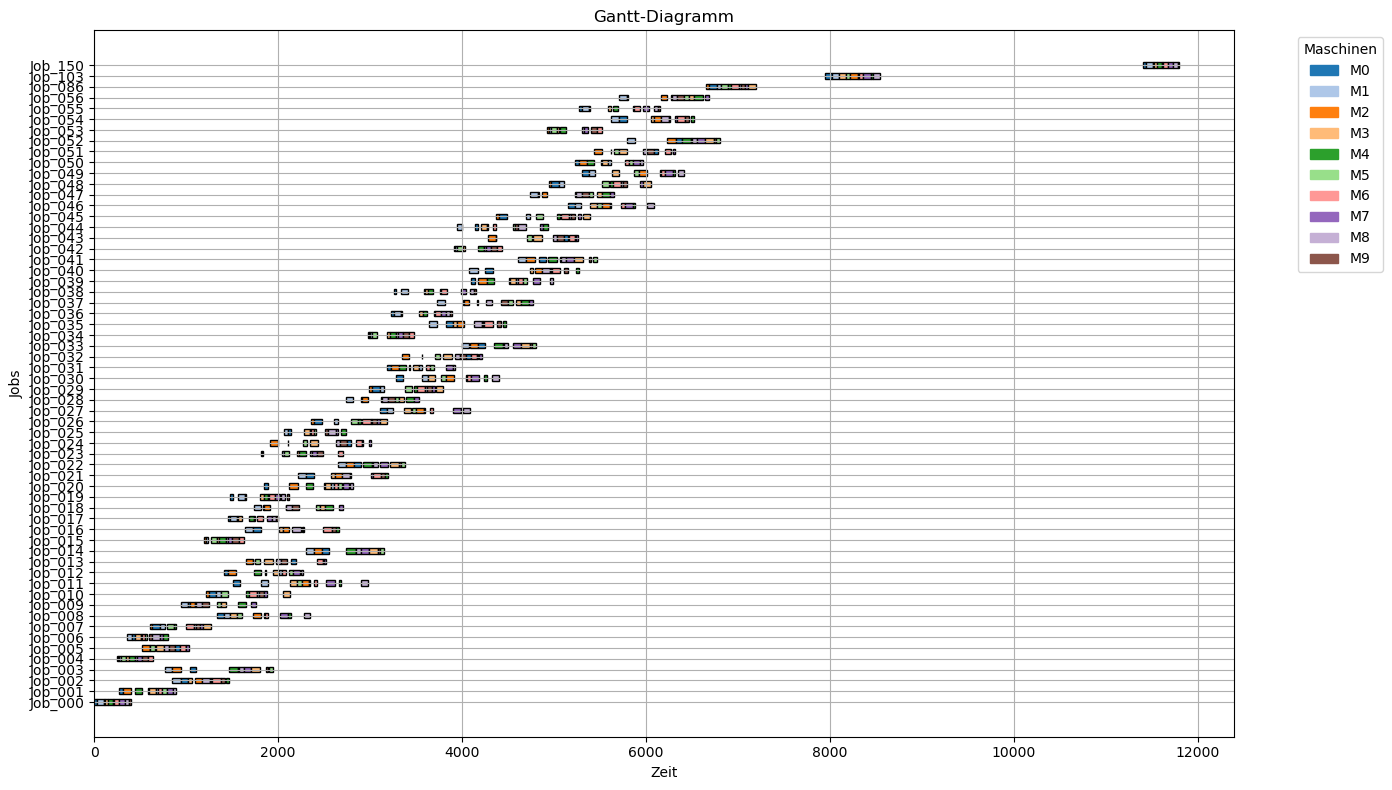

✅ Keine Maschinenkonflikte gefunden
✅ Für alle Jobs ist die Operationssequenz korrekt.
✅ Alle Operation starten erst nach Arrival des Job
✅ Zeitliche technologische Reihenfolge korrekt.

✅ Alle Constraints wurden erfüllt.



True

In [19]:
# show.plot_gantt_machines(df_plan)
show.plot_gantt_jobs(df_plan)
check.check_all_constraints(df_plan)

### Simulation

In [20]:
simulation = ProductionDaySimulation(df_plan, vc=0.35)
df_execution, df_undone = simulation.run(start_time = day_start, end_time=day_end)

[00:00:00] Job_000 started on M0
[00:13:11] Job_000 finished on M0 (after 13 minutes 12 seconds)
[00:29:00] Job_000 started on M1
[01:57:52] Job_000 finished on M1 (after 88 minutes 52 seconds)
[01:57:52] Job_000 started on M2
[02:10:17] Job_000 finished on M2 (after 12 minutes 25 seconds)
[02:10:17] Job_000 started on M3
[02:54:48] Job_000 finished on M3 (after 44 minutes 31 seconds)
[02:54:48] Job_000 started on M4
[03:45:13] Job_000 finished on M4 (after 50 minutes 25 seconds)
[03:45:13] Job_000 started on M5
[03:54:31] Job_000 finished on M5 (after 09 minutes 18 seconds)
[03:54:31] Job_000 started on M6
[04:06:36] Job_004 started on M2
[04:25:46] Job_004 finished on M2 (after 19 minutes 10 seconds)
[04:25:46] Job_004 started on M0
[04:34:01] Job_004 finished on M0 (after 08 minutes 15 seconds)
[04:34:01] Job_001 started on M0
[04:34:01] Job_004 started on M1
[04:38:45] Job_000 finished on M6 (after 44 minutes 14 seconds)
[04:38:45] Job_000 started on M7
[05:06:45] Job_004 finished 

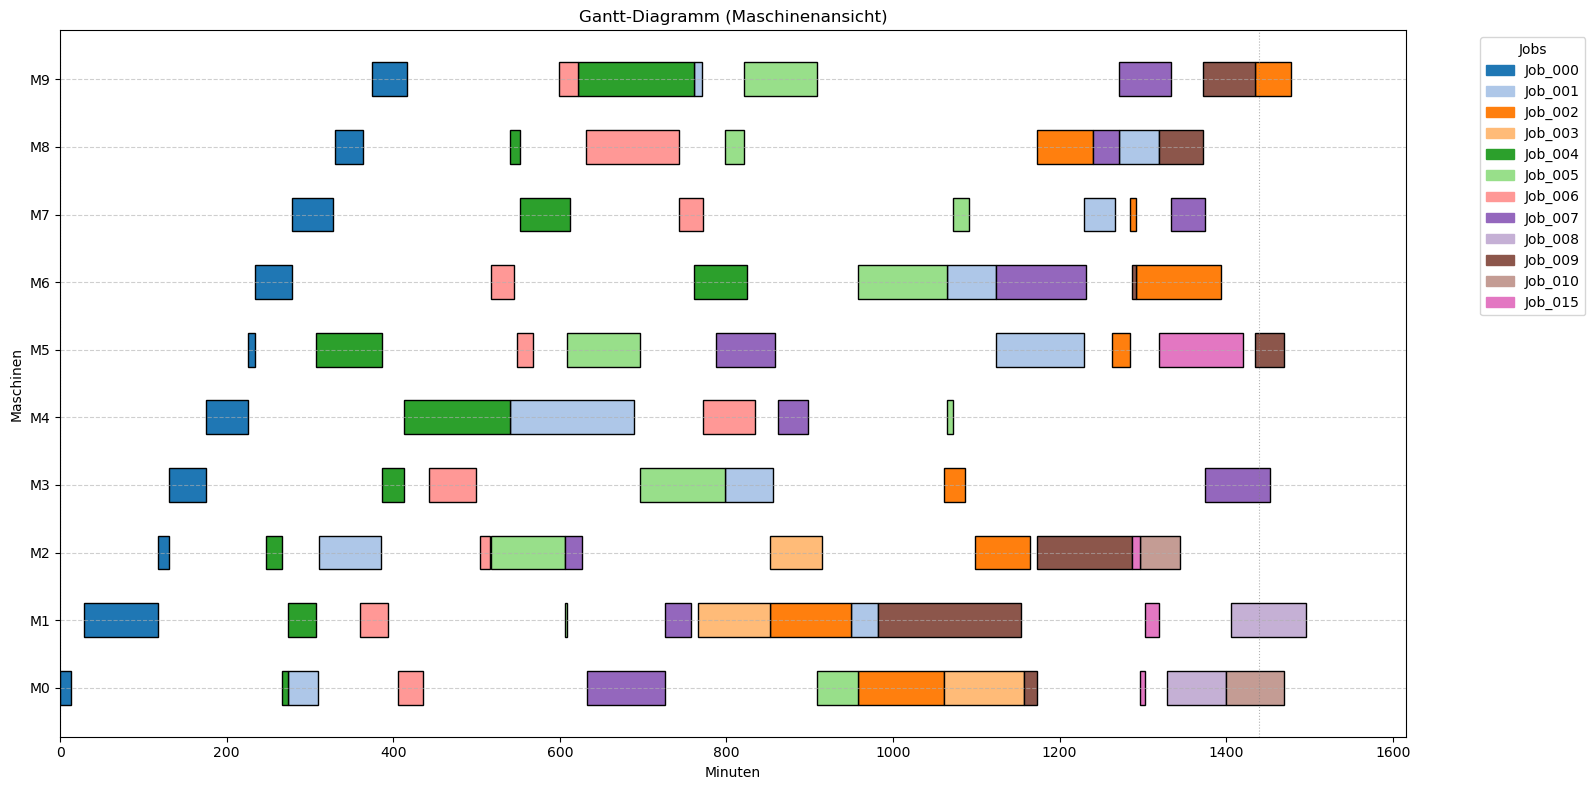

In [21]:
if not df_execution.empty:
    show.plot_gantt_machines(df_execution, duration_column="Simulated Processing Time")
else:
    print(f"Nothing executed on day {day_numb}")

In [22]:
df_execution

,Job,Operation,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
0,Job_000,0,0.00,M0,0.00,13.20,13.20,13.20
1,Job_000,1,0.00,M1,29.00,88.87,117.87,117.87
2,Job_000,2,0.00,M2,117.87,12.42,130.29,130.29
3,Job_000,3,0.00,M3,130.29,44.52,174.81,174.81
4,Job_000,4,0.00,M4,174.81,50.41,225.22,225.22
...,...,...,...,...,...,...,...,...
82,Job_010,1,891.94,M0,1400.21,69.67,577.94,1469.88
83,Job_015,0,1197.28,M2,1286.48,9.66,98.86,1296.14
84,Job_015,1,1197.28,M0,1296.14,6.49,105.35,1302.63
85,Job_015,2,1197.28,M1,1302.63,16.13,121.48,1318.76


In [23]:
df_undone

,Job,Operation,Arrival,Machine,Planned Start,Processing Time
19,Job_010,2,891.94,M1,1328.88,46.0
67,Job_015,4,1197.28,M3,1333.94,26.0
68,Job_015,5,1197.28,M4,1359.94,69.0
16,Job_009,7,781.95,M3,1381.54,52.0
20,Job_010,3,891.94,M5,1382.14,74.0
...,...,...,...,...,...,...
508,Job_150,5,11404.04,M5,11605.04,11.0
509,Job_150,6,11404.04,M6,11616.04,62.0
510,Job_150,7,11404.04,M7,11678.04,56.0
511,Job_150,8,11404.04,M8,11734.04,44.0


## Export

In [24]:
df_jssp.to_csv("data/07_tardiness_init_jssp.csv", index = False)
df_times.to_csv("data/07_tardiness_init_times.csv", index = False)

#### Day 0 

In [25]:
df_plan.to_csv("data/07_tardiness_init_plan.csv", index = False)
df_execution.to_csv("data/07_tardiness_init_execution.csv", index = False)
df_undone.to_csv("data/07_tardiness_init_undone.csv", index = False)

In [26]:
df_execution.to_csv("data/07_tardiness_init_execution.csv", index = False)

In [27]:
df_undone.to_csv("data/07_tardiness_init_undone.csv", index = False)